In [2]:
import math
import copy
from tqdm import tqdm

import numpy as np
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
import plotly.offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sbemdb import SBEMDB
from cleandb import clean_db, clean_db_uct

from distance import distance
from findpath import find_path

import import_ipynb
from FitterMod import Fitter

importing Jupyter notebook from FitterMod.ipynb


In [3]:
db = SBEMDB() # connect to DB
db = clean_db(db)
db.nodetypes()

trees Before 398
trees After 46
nodes Before 37481
nodes After 16320
nodecons Before 73994
nodecons After 32548
syncons Before 1199
syncons After 826
synapses Before 552
synapses After 535


{1: 'Soma', 2: 'ExitPoint', 3: 'TreeNode', 5: 'PresynTerm', 6: 'PostsynTerm'}

In [4]:
node_ids_db = list(db.nodeDetails('tid==444 and typ=6').keys())
segments = pd.read_csv('segments_table.csv')
segments.head()

,segment_id,branch_id,type,depth,is_synapse,node_id,point_node_id
0,0,2137,main,0,False,2137,2137
1,0,2137,main,0,False,3477,2137
2,0,2137,main,0,False,3478,3477
3,0,2137,main,0,False,3479,3478
4,0,2137,main,0,False,3480,3479


In [5]:
x, y, z, nid = db.nodexyz()

coord_nid = {} # {(coords): nid}
nid_coord = {} # {nid: (coords)}
for i in range(len(x)):
    coord_nid[(x[i], y[i], z[i])] = nid[i]
    nid_coord[nid[i]] = (x[i], y[i], z[i])

In [6]:
x,y,z = db.segments(444)

G = nx.Graph() # graph of connected node ids given segments

for i in range(len(x) - 1):
    if not math.isnan(x[i]) and not math.isnan(x[i+1]):
        G_nid1 = coord_nid[(x[i], y[i], z[i])]
        G_nid2 = coord_nid[(x[i+1], y[i+1], z[i+1])]
        G.add_edge(G_nid1, G_nid2, distance=distance(x[i], y[i], z[i], x[i+1], y[i+1], z[i+1]))

In [7]:
def get_length(segment_id):
    segment_nodes = segments[segments['segment_id'] == segment_id]
    start_node = segment_nodes.iloc[-1]['node_id']
    end_node = segment_nodes.iloc[0]['point_node_id']
    length = nx.dijkstra_path_length(G, start_node, end_node, 'distance')
    return length

In [8]:
segment_ids = segments['segment_id'].unique()
seg_n_synapses = {id: segments[segments['segment_id'] == id].drop_duplicates('node_id')['is_synapse'].sum() for id in segment_ids}
seg_n_syn_terminal = [seg_n_synapses[seg_id] for seg_id in segments[segments['type'] == 'ts']['segment_id'].unique()]
seg_n_syn_terminal_dict = {seg_id: seg_n_synapses[seg_id] for seg_id in segments[segments['type'] == 'ts']['segment_id'].unique()}
total_syn = sum(seg_n_syn_terminal) # total number of synapses 

In [9]:
# get main data
soma_x, soma_y, soma_z, soma_nid = db.nodexyz(f'tid=444 and typ=1')
xx, yy, zz = db.segments(444)
x, y, z, nid = db.nodexyz()

node_coords = {nid: [x[i], y[i], z[i]] for i, nid in enumerate(nid)}

# Distribution of Terminal Segments that contain a synapse on end edge

In [10]:
syn_x, syn_y, syn_z, _tid, _, _sid, _pre_nid, _post_nid = db.synapses(f'post.tid=444', extended=True) 

In [30]:
ts_ids = segments[segments['type'] == 'ts']['segment_id'].unique()

ts_lengths = []
num_edges = []
end_ts_synapses_node_ids = []

ts_lengths_short = {} # dict of ts, length < 3

ts_empty_lengths = {}
end_ts_empty_node_ids = []

for ts_id in ts_ids:
    sub_data = segments[segments['segment_id'] == ts_id]
    last_node = sub_data.iloc[-1]
    length = get_length(ts_id)
    if last_node['is_synapse']:
        if length < 3:
            ts_lengths_short[ts_id] = length
        end_ts_synapses_node_ids.append(last_node['node_id'])
        ts_lengths.append(length)
        num_edges.append(len(sub_data))
    else:
        end_ts_empty_node_ids.append(last_node['node_id'])
        ts_empty_lengths[ts_id] = length

ts_lengths, num_edges = (list(t) for t in zip(*sorted(zip(ts_lengths, num_edges))))

end_syn_node_x = syn_x[np.isin(_post_nid, end_ts_synapses_node_ids)]
end_syn_node_y = syn_y[np.isin(_post_nid, end_ts_synapses_node_ids)]
end_syn_node_z = syn_z[np.isin(_post_nid, end_ts_synapses_node_ids)]
end_synapse_ids = _sid[np.isin(_post_nid, end_ts_synapses_node_ids)]

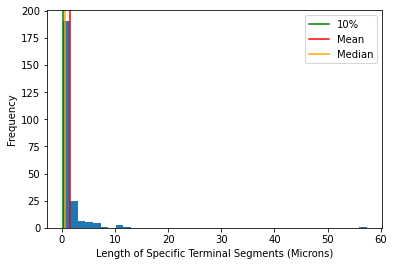

In [12]:
np.warnings.filterwarnings('ignore')

plt.hist(ts_lengths, bins=40)
plt.xlabel("Length of Specific Terminal Segments (Microns)")
plt.ylabel("Frequency")

plt.axvline(np.percentile(ts_lengths, 10), color="green", label='10%')
plt.axvline(np.mean(ts_lengths), color="red", label='Mean')
plt.axvline(np.median(ts_lengths), color="orange", label='Median')
plt.legend();

'\nplt.axvline(np.percentile(ts_lengths[:-1], 10), color="green", label=\'10%\')\nplt.axvline(np.mean(ts_lengths[:-1]), color="red", label=\'Mean\')\nplt.axvline(np.median(ts_lengths[:-1]), color="orange", label=\'Median\')\nplt.legend();\n'

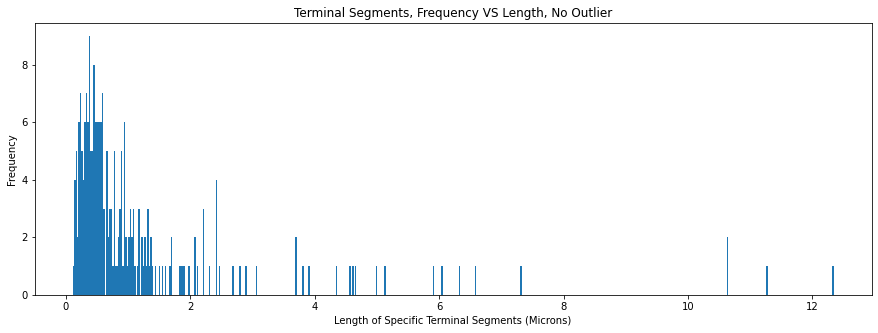

In [13]:
plt.figure(figsize=(15,5))
plt.hist(ts_lengths[:-1], bins=520)
plt.xlabel("Length of Specific Terminal Segments (Microns)")
plt.ylabel("Frequency")
plt.title("Terminal Segments, Frequency VS Length, No Outlier")
'''
plt.axvline(np.percentile(ts_lengths[:-1], 10), color="green", label='10%')
plt.axvline(np.mean(ts_lengths[:-1]), color="red", label='Mean')
plt.axvline(np.median(ts_lengths[:-1]), color="orange", label='Median')
plt.legend();
'''

,sumsquare_error,log_lik,max_lik,aic,bic,kl_div
lognorm,0.007112,920.439264,inf,-1834.878529,-2451.711459,inf
expon,0.140032,2121.487437,inf,-4238.974874,-1750.909400,inf
exponpow,0.241712,1059.656633,inf,-2113.313266,-1616.068119,inf
gamma,0.816942,2485.122503,inf,-4964.245006,-1327.444525,inf


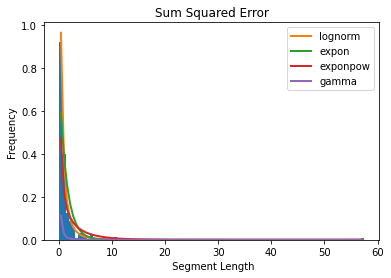

In [14]:
dist_ts_segments = Fitter(ts_lengths, distributions = "common", verbose=False)
dist_ts_segments.fit()
dist_ts_segments.summary()

,sumsquare_error,log_lik,max_lik,aic,bic,kl_div
lognorm,0.337146,459.662757,inf,-913.325513,-1529.661526,inf
expon,0.842259,552.076404,inf,-1100.152808,-1319.050197,inf
exponpow,1.524850,502.491892,inf,-998.983783,-1173.505273,inf
gamma,2.526885,578.899715,inf,-1151.799429,-1054.303780,inf


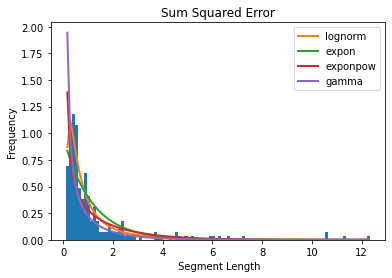

In [15]:
dist_ts_segments = Fitter(ts_lengths[:-1], distributions = "common", verbose=False)
dist_ts_segments.fit()
dist_ts_segments.summary()

Text(0, 0.5, 'Edge Number')

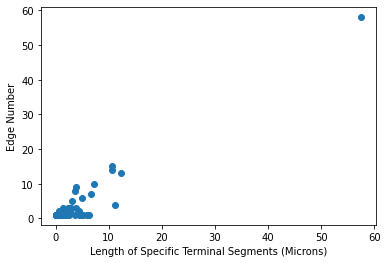

In [16]:
plt.scatter(ts_lengths, num_edges)
plt.xlabel("Length of Specific Terminal Segments (Microns)")
plt.ylabel("Edge Number")

Text(0.5, 1.0, 'Terminal Segments, Edge Number VS Length, No Outlier')

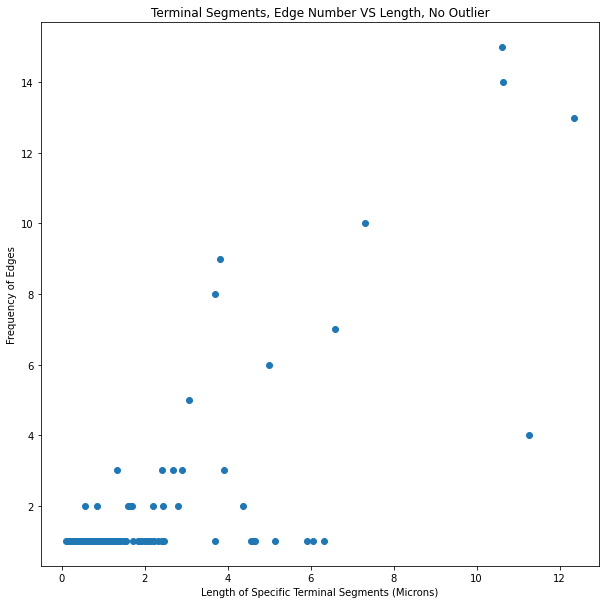

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(ts_lengths[:-1], num_edges[:-1])
plt.xlabel("Length of Specific Terminal Segments (Microns)")
plt.ylabel("Frequency of Edges")
plt.title("Terminal Segments, Edge Number VS Length, No Outlier")

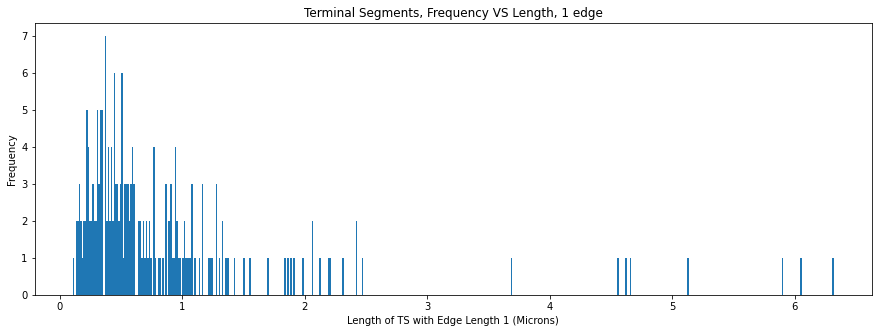

In [18]:
edge_one = [ts_lengths[i] for i, x in enumerate(num_edges) if x == 1]
plt.figure(figsize=(15,5))
plt.hist(edge_one, bins=500)
plt.xlabel("Length of TS with Edge Length 1 (Microns)")
plt.ylabel("Frequency");
plt.title("Terminal Segments, Frequency VS Length, 1 edge")
plt.show()

# Distribution of Terminal Segments that do not contain a synapse on end edge

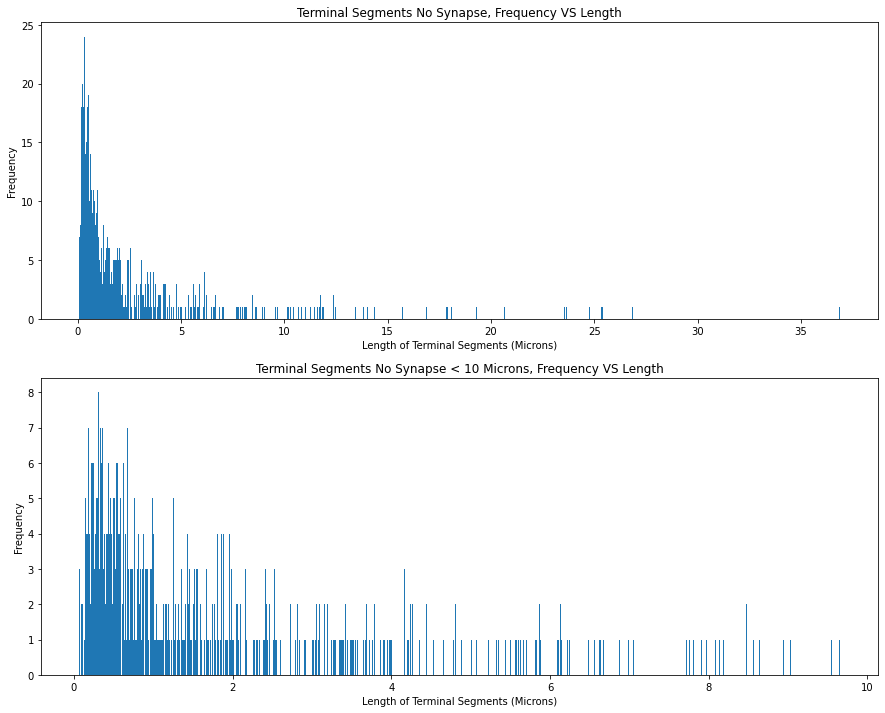

In [61]:
all_ts = [items for i, items in ts_empty_lengths.items()]
short_ts = [items for i, items in ts_empty_lengths.items() if items < 10]

fig, ax = plt.subplots(2 ,figsize = (15,12))

ax[0].hist(all_ts, bins=750)
ax[0].set_xlabel('Length of Terminal Segments (Microns)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Terminal Segments No Synapse, Frequency VS Length')

ax[1].hist(short_ts, bins=750)
ax[1].set_xlabel('Length of Terminal Segments (Microns)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Terminal Segments No Synapse < 10 Microns, Frequency VS Length')

plt.show()

# Visualize Branches

In [ ]:
def get_branch_coords(branch_id):
    branch_nodes = segments.loc[segments['branch_id'] == branch_id, ['node_id', 'point_node_id']].values
    branch_x = []
    branch_y = []
    branch_z = []

    for node_id, point_node_id in branch_nodes:
        coords_1 = node_coords[node_id]
        coords_2 = node_coords[point_node_id]
        branch_x += [coords_1[0], coords_2[0], np.nan]
        branch_y += [coords_1[1], coords_2[1], np.nan]
        branch_z += [coords_1[2], coords_2[2], np.nan]
    return branch_x, branch_y, branch_z

def generate_color():
    r = np.random.randint(0, 256)
    g = np.random.randint(0, 256)
    b = np.random.randint(0, 256)
    return f'rgb({r}, {g}, {b})'

def get_branches_coords(branch_ids):
    branch_xs = []
    branch_ys = []
    branch_zs = []
    colors = []
    
    for branch_id in branch_ids:
        branch_x, branch_y, branch_z = get_branch_coords(branch_id)
        color = generate_color()
        branch_xs.append(branch_x)
        branch_ys.append(branch_y)
        branch_zs.append(branch_z)
        colors.append(color)
    return branch_xs, branch_ys, branch_zs, colors

In [ ]:
def visualize_branches(branche_ids, main_branch=True):
    branch_xs, branch_ys, branch_zs, colors = get_branches_coords(branche_ids)
    main_x, main_y, main_z = [], [], []
    if main_branch:
        main_x, main_y, main_z = get_branch_coords(2137)
        
    ## Scatters for branches
    branch_scatters = []
    for i in range(len(branch_xs)):
        branch_scatters.append(
                                go.Scatter3d(x=branch_xs[i], y=branch_ys[i], z=branch_zs[i],
                                           mode='lines',
                                           hoverinfo='text',
                                           hovertext=[],
                                           opacity=1,
                                           name='segment',
                                           line=dict(
                                                width=5
                                           ),
                                           marker=dict(
                                                color=colors[i],
                                                size=15,
                                                opacity=1
                                            ))
        )
        
        fig = go.Figure(data=[
                          go.Scatter3d(x=soma_x, y=soma_y, z=soma_z,
                                       mode='markers',
                                       hoverinfo='text',
                                       hovertext=[],
                                       opacity=1,
                                       name='SOMA',
                                       marker=dict(
                                            color='black',
                                            size=4,
                                            opacity=1
                                        )),
                          go.Scatter3d(x=xx, y=yy, z=zz,
                                       mode='lines',
                                       hoverinfo='text',
                                       hovertext=[],
                                       opacity=1,
                                       name='main',
                                       line=dict(
                                            width=2
                                       ),
                                       marker=dict(
                                            color='black',
                                            size=15,
                                            opacity=1
                                        )),
                          go.Scatter3d(x=main_x, y=main_y, z=main_z,
                                       mode='lines',
                                       hoverinfo='text',
                                       hovertext=[],
                                       opacity=1,
                                       name='main segment',
                                       line=dict(
                                            width=5
                                       ),
                                       marker=dict(
                                            color='purple',
                                            size=15,
                                            opacity=1
                                        ))
                         ] + branch_scatters + [  # include outlier here
                          go.Scatter3d(x=syn_x, y=syn_y, z=syn_z,
                                       mode='markers',
                                       hoverinfo='text',
                                       hovertext=[],
                                       opacity=1,
                                       name='synapses',
                                       line=dict(
                                            width=5
                                       ),
                                       marker=dict(
                                            color='red',
                                            size=3,
                                            opacity=1
                                        )),
                          go.Scatter3d(x=end_syn_node_x, y=end_syn_node_y, z=end_syn_node_z,
                                       mode='markers',
                                       hoverinfo='text',
                                       hovertext=[],
                                       opacity=1,
                                       name='synapse on terminal end of ts',
                                       line=dict(
                                            width=5
                                       ),
                                       marker=dict(
                                            color='blue',
                                            size=3,
                                            opacity=1
                                        ))
        
        
        ])

    fig.update_layout(title="Segments",
                      showlegend=False,
                        scene=dict(
                            xaxis=dict(nticks=5, range=[50, 300], showbackground=False, showticklabels=False, title=''),
                            yaxis=dict(nticks=13, range=[50, 750], showbackground=False, showticklabels=False, title=''),
                            zaxis=dict(nticks=6, range=[50, 350], showbackground=False, showticklabels=False, title=''),
                            aspectmode='data'
                        ),
                        scene_camera=dict(
                            eye=dict(x=-0.8, y=-0.8, z=0.05),
                            up=dict(x=0, y=0, z=1),
                            center=dict(x=0, y=0, z=0)
                        )
                    )

    plotly.offline.plot(fig, auto_open=True)
    fig.show()

In [ ]:
branch_ids_sample = segments['branch_id'].unique()[3:4]
visualize_branches(branch_ids_sample)